# Solar project - Machine Learning

#### Imports and installations

In [206]:
"""%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install numpy
%pip install scipy
%pip install dataprep"""

'%pip install pandas\n%pip install matplotlib\n%pip install seaborn\n%pip install scikit-learn\n%pip install numpy\n%pip install scipy\n%pip install dataprep'

In [207]:
import sys
assert sys.version_info >= (3, 7)

from packaging import version
import sklearn
print(sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import pandas as pd
import os
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


1.4.2


##### Check current directory

In [208]:
current_directory = os.getcwd()
print("Current directory:", current_directory)

Current directory: c:\HoGent\Jaar2\ML\Project\MachineLearningProject_Solar\script


#### Load CSV and excel files

In [209]:
# Load CSV files
csv1 = pd.read_csv('https://raw.githubusercontent.com/HOGENT-ML/course/main/datasets/solar.csv')
csv2 = pd.read_csv('https://raw.githubusercontent.com/HOGENT-ML/course/main/datasets/weather.csv') 

# Load Excel file
xlsx = pd.read_excel('../data/sunrise-sunset.xlsx')


##### Convert excel to CSV

In [210]:
xlsx.to_csv('../data/sunrise-sunset.csv', index=False)


##### Load converted CSV

In [211]:
csv3 = pd.read_csv('../data/sunrise-sunset.csv')

#### Create dataframes

In [212]:
df_solar = pd.DataFrame(csv1)
df_weather = pd.DataFrame(csv2)
df_sun = pd.DataFrame(csv3)

#### Convert timestamps to datetime

##### Convert in solar.csv

###### extract timezone

In [213]:
import pandas as pd

# Assuming df_solar is your DataFrame and contains the columns 'timestamp' and 'kwh'

# Convert the 'timestamp' column to string if it is not already
df_solar['timestamp'] = df_solar['timestamp'].astype(str)

# Create a new column 'last_3_chars' that contains the last 3 characters of the 'timestamp' string
df_solar['timezone'] = df_solar['timestamp'].str[-3:]


# Display the DataFrame to check the results
print(df_solar)


                          timestamp        kwh timezone
0     2023-03-11 16:00:10.160454+01     0.5400      +01
1     2023-03-11 17:00:10.217795+01     1.0200      +01
2     2023-03-11 18:00:10.284064+01     1.1700      +01
3     2023-03-11 19:00:10.224836+01     1.1800      +01
4     2023-03-11 20:00:10.201847+01     1.1800      +01
...                             ...        ...      ...
9700  2024-04-19 06:00:10.326636+02  2417.3321      +02
9701  2024-04-19 07:00:10.424826+02  2417.3321      +02
9702  2024-04-19 08:00:10.360449+02  2417.3336      +02
9703  2024-04-19 09:00:10.437154+02  2417.3701      +02
9704  2024-04-19 10:00:10.748713+02  2417.4788      +02

[9705 rows x 3 columns]


###### convert to datetime and set timezone to UTC

In [214]:
df_solar['timestamp'] = pd.to_datetime(df_solar['timestamp'], utc=True)

##### Convert in weather.csv

In [215]:
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])

##### Convert in sunrise-sunset.csv

In [216]:
df_sun['datum'] = pd.to_datetime(df_sun['datum'])

#### Merge solar.csv and weather.csv on timestamp

In [217]:
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'], utc=True)

In [218]:
df_merged = pd.merge_asof(df_solar,df_weather,on="timestamp",direction="nearest")

##### Convert timestamp to wanted format

In [219]:
df_merged['timestamp2'] = df_merged['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [220]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9705 entries, 0 to 9704
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   timestamp                    9705 non-null   datetime64[ns, UTC]
 1   kwh                          9705 non-null   float64            
 2   timezone                     9705 non-null   object             
 3   FID                          9705 non-null   object             
 4   the_geom                     9705 non-null   object             
 5   code                         9705 non-null   int64              
 6   precip_quantity              1552 non-null   float64            
 7   precip_range                 1557 non-null   float64            
 8   temp                         9705 non-null   float64            
 9   temp_min                     388 non-null    float64            
 10  temp_max                     388 non-null    flo

##### Split timestamp - date and time

In [221]:
df_merged['date'] = df_merged['timestamp2'].apply(lambda x: x.split(' ')[0])
print(df_merged['date'])
df_merged['time'] = df_merged['timestamp2'].apply(lambda x: x.split(' ')[1])
print(df_merged['time'])

0       2023-03-11
1       2023-03-11
2       2023-03-11
3       2023-03-11
4       2023-03-11
           ...    
9700    2024-04-19
9701    2024-04-19
9702    2024-04-19
9703    2024-04-19
9704    2024-04-19
Name: date, Length: 9705, dtype: object
0       15:00:10
1       16:00:10
2       17:00:10
3       18:00:10
4       19:00:10
          ...   
9700    04:00:10
9701    05:00:10
9702    06:00:10
9703    07:00:10
9704    08:00:10
Name: time, Length: 9705, dtype: object


##### Prepare data to merge with sunrise-sunset.csv

In [222]:
df_merged['date'] = pd.to_datetime(df_merged['date'])

##### Merge data with sunrise-sunset.csv

In [223]:
df_merged = pd.merge(df_merged,df_sun,left_on="date",right_on="datum",how="left")

#### Create new column for the generation of solar power in KwH/h

In [224]:
df_merged['kwh_per_hour'] = df_merged['kwh'].diff()


#### Convert all dates with datatype object to datetime

In [225]:
df_merged["timestamp"] = pd.to_datetime(df_merged["timestamp"])
df_merged["datum"] = pd.to_datetime(df_merged["datum"])


##### Convert times to datetime

## Cleaning data

### Drop unnecessary columns

In [226]:
df_merged.drop("temp_min", axis=1, inplace=True)
df_merged.drop("temp_max", axis=1, inplace=True)
df_merged.drop("temp_grass_min", axis=1, inplace=True)
df_merged.drop("weather_current", axis=1, inplace=True)
df_merged.drop("short_wave_from_sky_24hours", axis=1, inplace=True)
df_merged.drop("sun_duration_24hours", axis=1, inplace=True)
df_merged.drop("precip_quantity", axis=1, inplace=True)
df_merged.drop("precip_range", axis=1, inplace=True)
df_merged.drop("wind_speed_unit", axis=1, inplace=True)
df_merged.drop("FID", axis=1, inplace=True)
df_merged.drop("the_geom", axis=1, inplace=True)
df_merged.drop("code", axis=1, inplace=True)
df_merged.drop("pressure_station_level", axis=1, inplace=True)
df_merged.drop("time", axis=1, inplace=True)
df_merged.drop("wind_direction", axis=1, inplace=True)
df_merged.drop("datum", axis=1, inplace=True)
df_merged.drop("timestamp2", axis=1, inplace=True)
df_merged.drop("wind_speed", axis=1, inplace=True)
df_merged.drop("wind_peak_speed", axis=1, inplace=True)

##### drop rows where kwh is 0

In [227]:
df_merged = df_merged[df_merged.kwh != 0]

#### drop rows where pressure is empty (null)

In [228]:
df_merged=df_merged.dropna(subset=['pressure'])

#### fill empty values with mean 

In [229]:
df_merged["cloudiness"].fillna(df_merged["cloudiness"].mean(), inplace=True)

##### fill empty values with mean

In [230]:
df_merged["humidity_relative"].fillna(df_merged["humidity_relative"].mean(), inplace=True)

#### fill empty rows in kwh_per_hour with 0

In [231]:
df_merged['kwh_per_hour'] = df_merged['kwh_per_hour'].fillna(0)

### Histograms

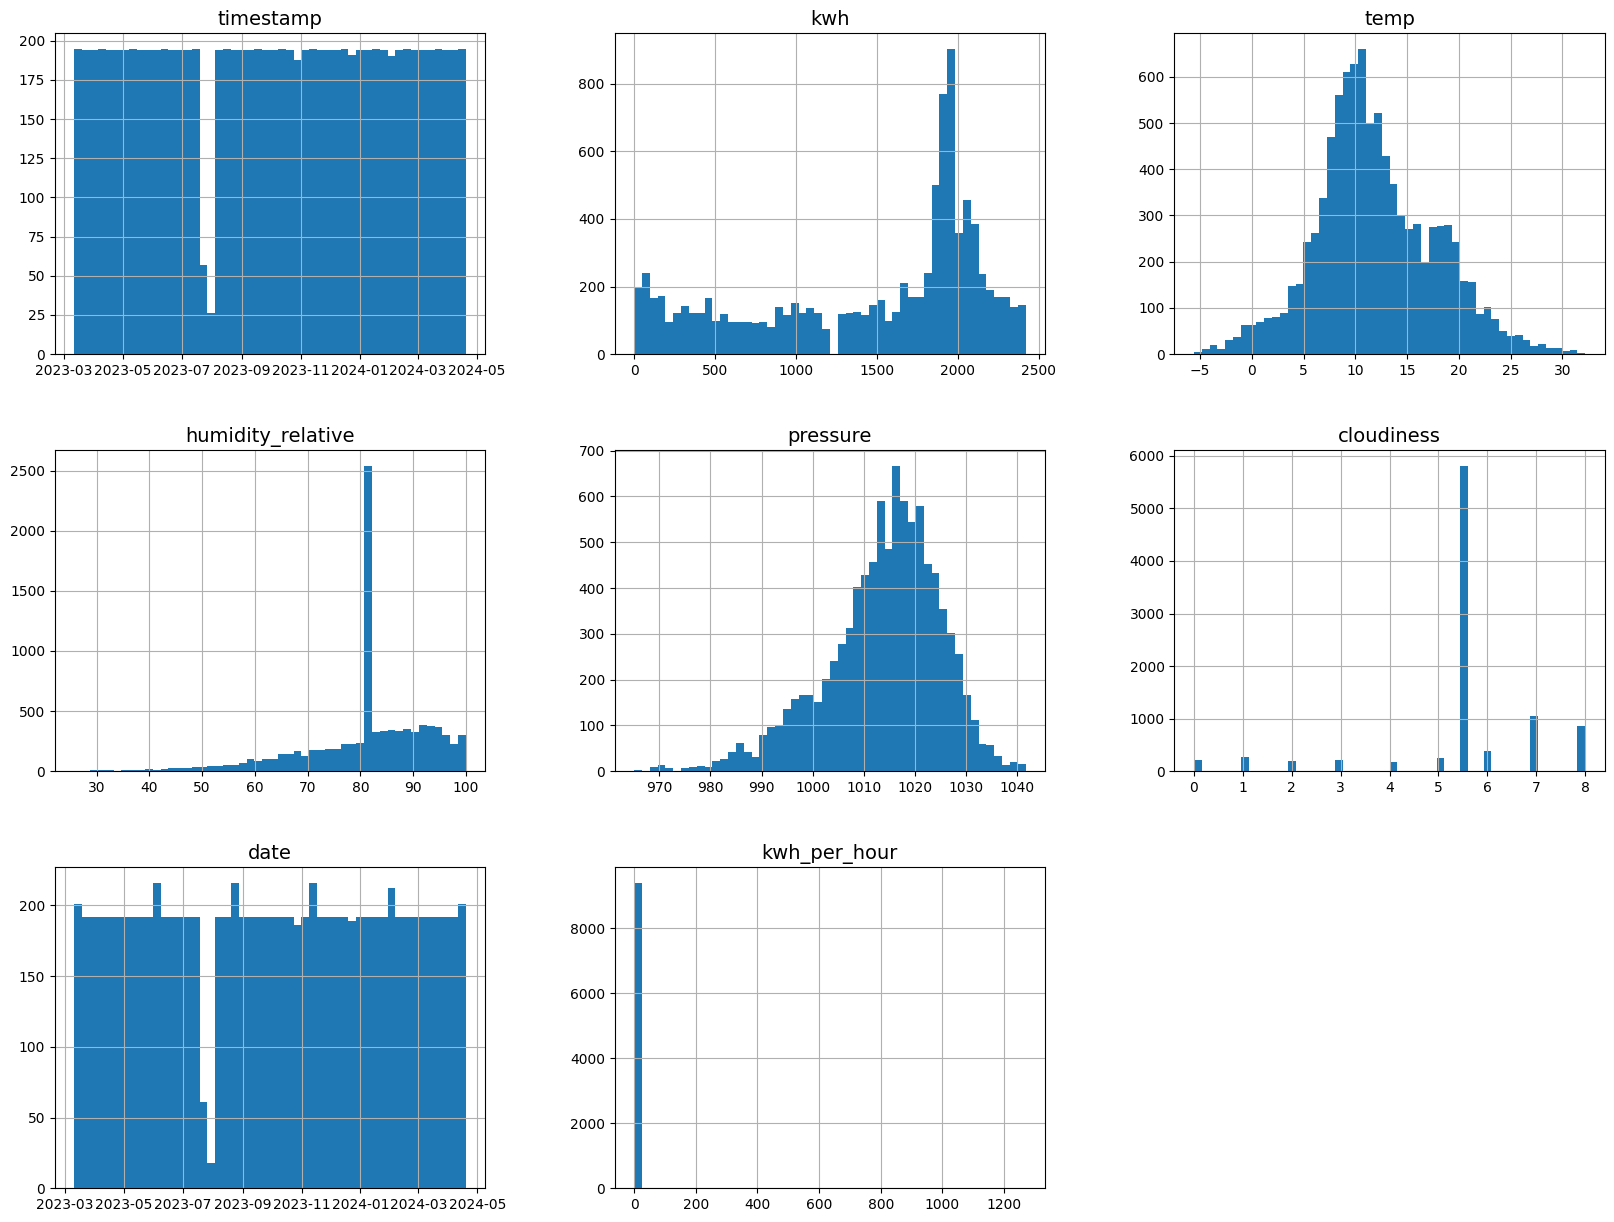

In [232]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df_merged.hist(bins=50, figsize=(20,15))
plt.show()

#### Correlation matrix

In [233]:
corr_matrix = df_merged.corr(numeric_only=True)
corr_matrix

,kwh,temp,humidity_relative,pressure,cloudiness,kwh_per_hour
kwh,1.000000,-0.195524,0.183442,-0.200952,0.087658,-0.008903
temp,-0.195524,1.000000,-0.443032,0.038379,-0.092445,0.021936
humidity_relative,0.183442,-0.443032,1.000000,-0.127868,0.084136,-0.009353
pressure,-0.200952,0.038379,-0.127868,1.000000,-0.175616,-0.002190
cloudiness,0.087658,-0.092445,0.084136,-0.175616,1.000000,-0.005222
kwh_per_hour,-0.008903,0.021936,-0.009353,-0.002190,-0.005222,1.000000


#### Scatter matrix

array([[<Axes: xlabel='kwh', ylabel='kwh'>,
        <Axes: xlabel='cloudiness', ylabel='kwh'>,
        <Axes: xlabel='temp', ylabel='kwh'>,
        <Axes: xlabel='humidity_relative', ylabel='kwh'>],
       [<Axes: xlabel='kwh', ylabel='cloudiness'>,
        <Axes: xlabel='cloudiness', ylabel='cloudiness'>,
        <Axes: xlabel='temp', ylabel='cloudiness'>,
        <Axes: xlabel='humidity_relative', ylabel='cloudiness'>],
       [<Axes: xlabel='kwh', ylabel='temp'>,
        <Axes: xlabel='cloudiness', ylabel='temp'>,
        <Axes: xlabel='temp', ylabel='temp'>,
        <Axes: xlabel='humidity_relative', ylabel='temp'>],
       [<Axes: xlabel='kwh', ylabel='humidity_relative'>,
        <Axes: xlabel='cloudiness', ylabel='humidity_relative'>,
        <Axes: xlabel='temp', ylabel='humidity_relative'>,
        <Axes: xlabel='humidity_relative', ylabel='humidity_relative'>]],
      dtype=object)

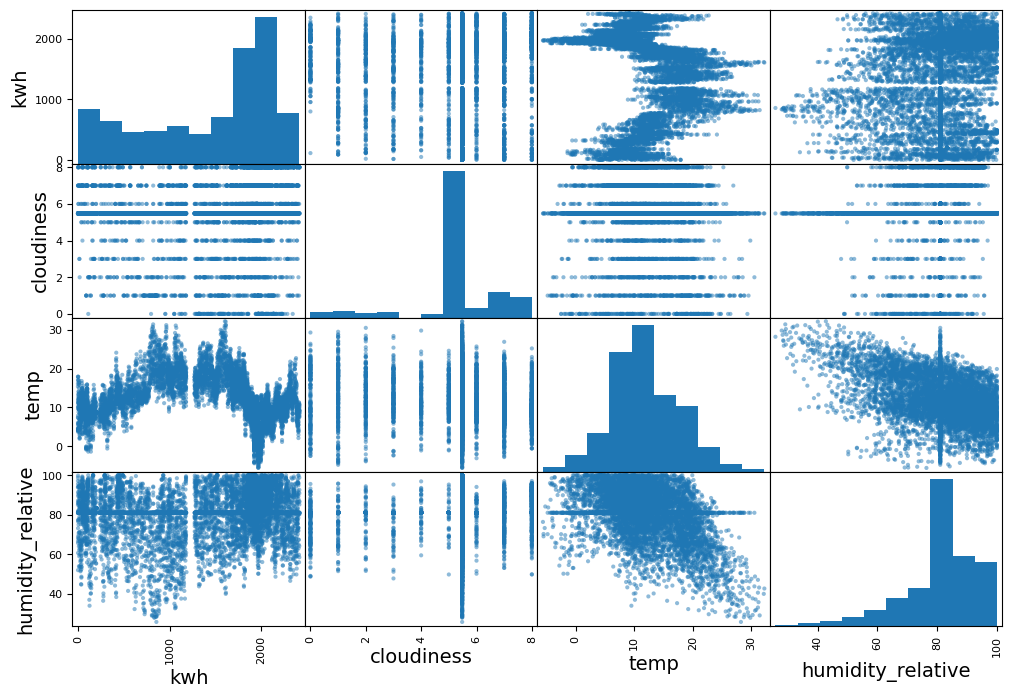

In [234]:
from pandas.plotting import scatter_matrix

attributes = ["kwh", "cloudiness", "temp",
              "humidity_relative"]
scatter_matrix(df_merged[attributes], figsize=(12, 8))

#### Dataprep report

In [235]:
import pandas as pd
import numpy as np

In [236]:
#report = create_report(df_merged)

In [237]:
#report

#### Boxplots to check for outliers


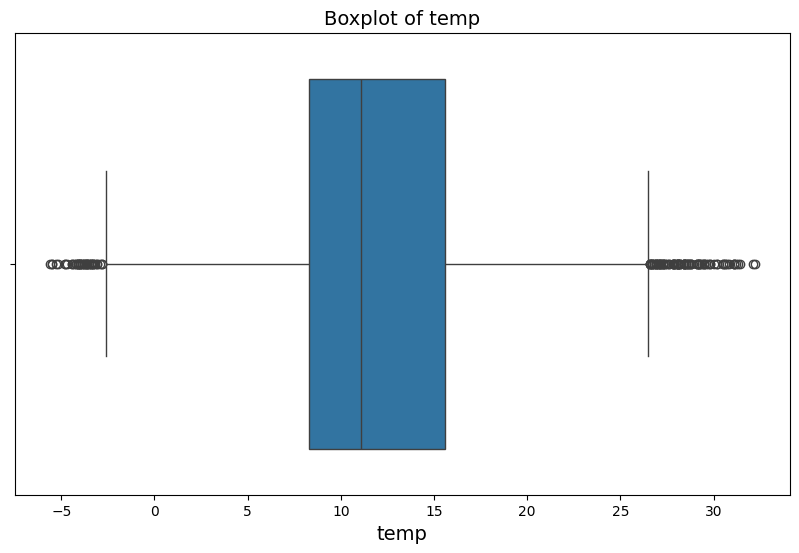

In [238]:
#boxplot wind_speed
plt.figure(figsize=(10,6))
sns.boxplot(x='temp', data=df_merged)
plt.title('Boxplot of temp')
plt.show()

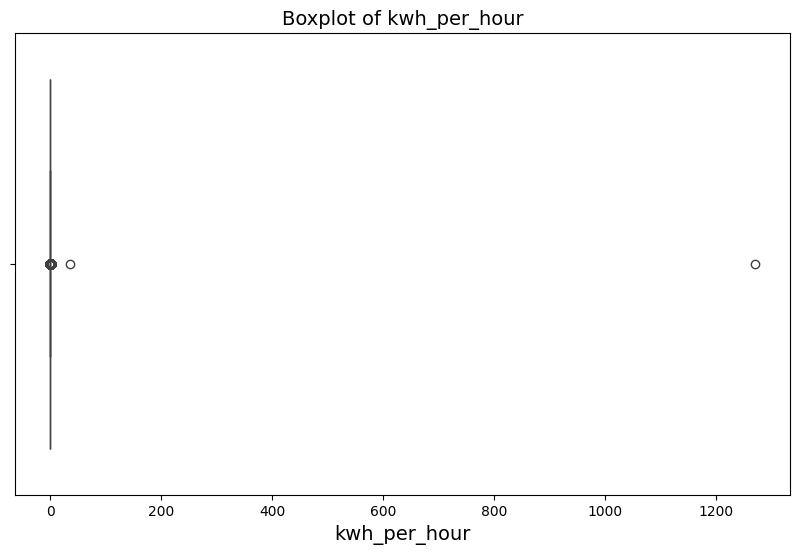

In [239]:
#boxplot wind_speed
plt.figure(figsize=(10,6))
sns.boxplot(x='kwh_per_hour', data=df_merged)
plt.title('Boxplot of kwh_per_hour')
plt.show()

#### Drop outliers in kwh_per_hour

In [240]:
df_merged = df_merged[(df_merged['kwh_per_hour'] <= 50) & (df_merged['kwh_per_hour'] >= -20)]


##### correlation matrix after dropping outliers on kwh_per_hour

In [241]:
df_merged

,timestamp,kwh,timezone,temp,humidity_relative,pressure,cloudiness,date,Opkomst,Op ware middag,Ondergang,kwh_per_hour
0,2023-03-11 15:00:10.160454+00:00,0.5400,+01,7.4,52.000000,1012.2,5.48144,2023-03-11,07:06:00,12:53:00,18:40:00,0.0000
1,2023-03-11 16:00:10.217795+00:00,1.0200,+01,5.8,81.024402,1011.5,7.00000,2023-03-11,07:06:00,12:53:00,18:40:00,0.4800
2,2023-03-11 17:00:10.284064+00:00,1.1700,+01,6.1,60.700000,1011.7,5.48144,2023-03-11,07:06:00,12:53:00,18:40:00,0.1500
3,2023-03-11 18:00:10.224836+00:00,1.1800,+01,5.4,65.700000,1011.9,5.48144,2023-03-11,07:06:00,12:53:00,18:40:00,0.0100
4,2023-03-11 19:00:10.201847+00:00,1.1800,+01,3.7,73.200000,1012.2,5.48144,2023-03-11,07:06:00,12:53:00,18:40:00,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
9700,2024-04-19 04:00:10.326636+00:00,2417.3321,+02,10.2,86.900000,1013.2,8.00000,2024-04-19,06:39:00,13:42:00,20:45:00,0.0000
9701,2024-04-19 05:00:10.424826+00:00,2417.3321,+02,8.0,98.800000,1013.6,5.48144,2024-04-19,06:39:00,13:42:00,20:45:00,0.0000
9702,2024-04-19 06:00:10.360449+00:00,2417.3336,+02,9.0,92.600000,1014.1,5.48144,2024-04-19,06:39:00,13:42:00,20:45:00,0.0015
9703,2024-04-19 07:00:10.437154+00:00,2417.3701,+02,10.6,81.024402,1013.5,8.00000,2024-04-19,06:39:00,13:42:00,20:45:00,0.0365


In [242]:
#correlation kwh_per_hour
corr_matrix = df_merged.corr(numeric_only=True)
corr_matrix["kwh_per_hour"].sort_values(ascending=False)

kwh_per_hour         1.000000
temp                 0.308743
pressure             0.120870
cloudiness          -0.117332
kwh                 -0.143371
humidity_relative   -0.391176
Name: kwh_per_hour, dtype: float64

#### transform sunrise, sunset and on true midday so it doesnt have summer/winter time

In [243]:
df_merged['date'] = df_merged['date'].astype(str)

##### add date to sunrise, sunset and midday

In [244]:
df_merged["Opkomst"] = pd.to_datetime(df_merged["date"] + ' ' + df_merged["Opkomst"], utc=True)
df_merged["Ondergang"] = pd.to_datetime(df_merged["date"] + ' ' + df_merged["Ondergang"], utc=True)
df_merged["Op ware middag"] = pd.to_datetime(df_merged["date"] + ' ' + df_merged["Op ware middag"], utc=True) 

##### subtract 1 hour if the timezone is in summer time

In [245]:
import pandas as pd
from datetime import timedelta

# Define a timedelta object representing one hour
one_hour = timedelta(hours=1)

# Apply the timedelta addition conditionally
df_merged.loc[df_merged['timezone'] == "+02", 'Opkomst'] -= one_hour
df_merged.loc[df_merged['timezone'] == "+02", 'Ondergang'] -= one_hour
df_merged.loc[df_merged['timezone'] == "+02", 'Op ware middag'] -= one_hour

# Print the results
print(df_merged['Opkomst'])
print(df_merged['Ondergang'])
print(df_merged['Op ware middag'])


0      2023-03-11 07:06:00+00:00
1      2023-03-11 07:06:00+00:00
2      2023-03-11 07:06:00+00:00
3      2023-03-11 07:06:00+00:00
4      2023-03-11 07:06:00+00:00
                  ...           
9700   2024-04-19 05:39:00+00:00
9701   2024-04-19 05:39:00+00:00
9702   2024-04-19 05:39:00+00:00
9703   2024-04-19 05:39:00+00:00
9704   2024-04-19 05:39:00+00:00
Name: Opkomst, Length: 9395, dtype: datetime64[ns, UTC]
0      2023-03-11 18:40:00+00:00
1      2023-03-11 18:40:00+00:00
2      2023-03-11 18:40:00+00:00
3      2023-03-11 18:40:00+00:00
4      2023-03-11 18:40:00+00:00
                  ...           
9700   2024-04-19 19:45:00+00:00
9701   2024-04-19 19:45:00+00:00
9702   2024-04-19 19:45:00+00:00
9703   2024-04-19 19:45:00+00:00
9704   2024-04-19 19:45:00+00:00
Name: Ondergang, Length: 9395, dtype: datetime64[ns, UTC]
0      2023-03-11 12:53:00+00:00
1      2023-03-11 12:53:00+00:00
2      2023-03-11 12:53:00+00:00
3      2023-03-11 12:53:00+00:00
4      2023-03-11 12:53:00+0

In [246]:
df_merged["Opkomst"] = df_merged["Opkomst"].dt.time
df_merged["Ondergang"] = df_merged["Ondergang"].dt.time
df_merged["Op ware middag"] = df_merged["Op ware middag"].dt.time

In [247]:
df_merged.head()

,timestamp,kwh,timezone,temp,humidity_relative,pressure,cloudiness,date,Opkomst,Op ware middag,Ondergang,kwh_per_hour
0,2023-03-11 15:00:10.160454+00:00,0.54,+01,7.4,52.000000,1012.2,5.48144,2023-03-11,07:06:00,12:53:00,18:40:00,0.00
1,2023-03-11 16:00:10.217795+00:00,1.02,+01,5.8,81.024402,1011.5,7.00000,2023-03-11,07:06:00,12:53:00,18:40:00,0.48
2,2023-03-11 17:00:10.284064+00:00,1.17,+01,6.1,60.700000,1011.7,5.48144,2023-03-11,07:06:00,12:53:00,18:40:00,0.15
3,2023-03-11 18:00:10.224836+00:00,1.18,+01,5.4,65.700000,1011.9,5.48144,2023-03-11,07:06:00,12:53:00,18:40:00,0.01
4,2023-03-11 19:00:10.201847+00:00,1.18,+01,3.7,73.200000,1012.2,5.48144,2023-03-11,07:06:00,12:53:00,18:40:00,0.00


##### graph of opkomst compared to date

In [250]:
df_merged['Opkomst'] = pd.to_datetime(df_merged['Opkomst'], format='%H:%M:%S')
df_merged['Opkomst'] = df_merged['Opkomst'].dt.strftime('%H:%M')

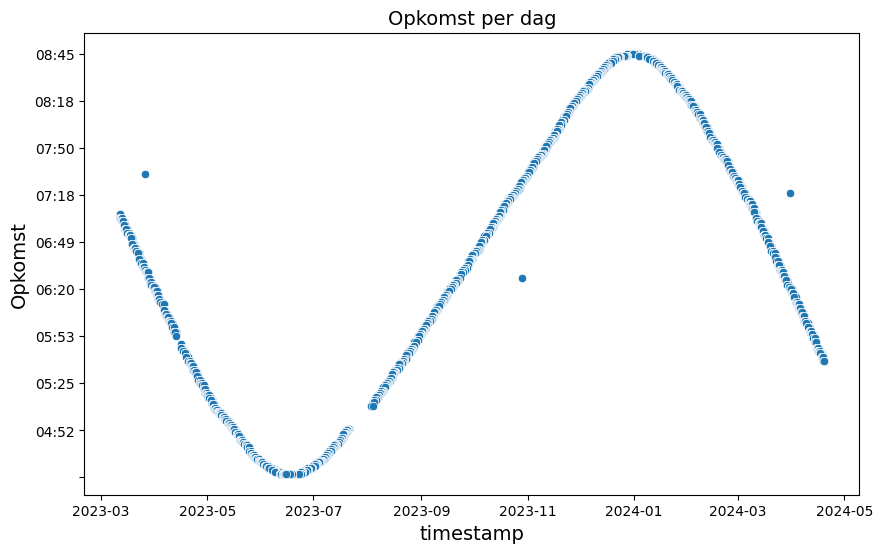

In [251]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Sort the DataFrame based on 'Opkomst' in descending order
df_merged_sorted = df_merged.sort_values(by='Opkomst', ascending=False)

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='timestamp', y='Opkomst', data=df_merged_sorted)
plt.title('Opkomst per dag')

# Adjust y-axis ticker
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Show the plot
plt.show()
 

In [252]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9395 entries, 0 to 9704
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   timestamp          9395 non-null   datetime64[ns, UTC]
 1   kwh                9395 non-null   float64            
 2   timezone           9395 non-null   object             
 3   temp               9395 non-null   float64            
 4   humidity_relative  9395 non-null   float64            
 5   pressure           9395 non-null   float64            
 6   cloudiness         9395 non-null   float64            
 7   date               9395 non-null   object             
 8   Opkomst            9395 non-null   object             
 9   Op ware middag     9395 non-null   object             
 10  Ondergang          9395 non-null   object             
 11  kwh_per_hour       9395 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6), object(5)

#### Put these columns: Opkomst , ondergang and Op ware middag on same timezone (no summer/winter time)

In [256]:
df_merged.head()

,timestamp,kwh,timezone,temp,humidity_relative,pressure,cloudiness,date,Opkomst,Op ware middag,Ondergang,kwh_per_hour
0,2023-03-11 15:00:10.160454+00:00,0.54,+01,7.4,52.000000,1012.2,5.48144,2023-03-11,07:06,12:53:00,18:40:00,0.00
1,2023-03-11 16:00:10.217795+00:00,1.02,+01,5.8,81.024402,1011.5,7.00000,2023-03-11,07:06,12:53:00,18:40:00,0.48
2,2023-03-11 17:00:10.284064+00:00,1.17,+01,6.1,60.700000,1011.7,5.48144,2023-03-11,07:06,12:53:00,18:40:00,0.15
3,2023-03-11 18:00:10.224836+00:00,1.18,+01,5.4,65.700000,1011.9,5.48144,2023-03-11,07:06,12:53:00,18:40:00,0.01
4,2023-03-11 19:00:10.201847+00:00,1.18,+01,3.7,73.200000,1012.2,5.48144,2023-03-11,07:06,12:53:00,18:40:00,0.00


In [257]:
#report= create_report(df_merged, title='Solar Power Report')
#report

## Feature engineering

#### timestamp opsplitsen uur  en en dag van het jaar, opkomst/ .../ omzetten naar float bv 06.34 -> 6.34

### Create new columns from timestamp

I do this so i can use the data in the model. I will use the hour of the day, the day of the year. I will also use the sunrise, sunset and midday times. I will convert these times to float so i can use them in the model.

In [258]:
df_merged['hour'] = df_merged['timestamp'].dt.hour
df_merged['day_of_year'] = df_merged['timestamp'].dt.dayofyear

#### Convert to float so i can use them in the model

In [259]:
df_merged['Ondergang'] = df_merged['Ondergang'].astype(str).str.replace(':','').astype(float)
df_merged['Opkomst'] = df_merged['Opkomst'].astype(str).str.replace(':','').astype(float)
df_merged['Op ware middag'] = df_merged['Op ware middag'].astype(str).str.replace(':','').astype(float)

In [260]:
df_merged.head()

,timestamp,kwh,timezone,temp,humidity_relative,pressure,cloudiness,date,Opkomst,Op ware middag,Ondergang,kwh_per_hour,hour,day_of_year
0,2023-03-11 15:00:10.160454+00:00,0.54,+01,7.4,52.000000,1012.2,5.48144,2023-03-11,706.0,125300.0,184000.0,0.00,15,70
1,2023-03-11 16:00:10.217795+00:00,1.02,+01,5.8,81.024402,1011.5,7.00000,2023-03-11,706.0,125300.0,184000.0,0.48,16,70
2,2023-03-11 17:00:10.284064+00:00,1.17,+01,6.1,60.700000,1011.7,5.48144,2023-03-11,706.0,125300.0,184000.0,0.15,17,70
3,2023-03-11 18:00:10.224836+00:00,1.18,+01,5.4,65.700000,1011.9,5.48144,2023-03-11,706.0,125300.0,184000.0,0.01,18,70
4,2023-03-11 19:00:10.201847+00:00,1.18,+01,3.7,73.200000,1012.2,5.48144,2023-03-11,706.0,125300.0,184000.0,0.00,19,70


In [261]:
#correlation kwh
corr_matrix = df_merged.corr(numeric_only=True)

corr_matrix["kwh_per_hour"].sort_values(ascending=False)

kwh_per_hour         1.000000
temp                 0.308743
Ondergang            0.225657
pressure             0.120870
hour                 0.077082
Op ware middag       0.020833
day_of_year         -0.042099
cloudiness          -0.117332
kwh                 -0.143371
Opkomst             -0.227183
humidity_relative   -0.391176
Name: kwh_per_hour, dtype: float64

In [262]:
df_merged.head()

,timestamp,kwh,timezone,temp,humidity_relative,pressure,cloudiness,date,Opkomst,Op ware middag,Ondergang,kwh_per_hour,hour,day_of_year
0,2023-03-11 15:00:10.160454+00:00,0.54,+01,7.4,52.000000,1012.2,5.48144,2023-03-11,706.0,125300.0,184000.0,0.00,15,70
1,2023-03-11 16:00:10.217795+00:00,1.02,+01,5.8,81.024402,1011.5,7.00000,2023-03-11,706.0,125300.0,184000.0,0.48,16,70
2,2023-03-11 17:00:10.284064+00:00,1.17,+01,6.1,60.700000,1011.7,5.48144,2023-03-11,706.0,125300.0,184000.0,0.15,17,70
3,2023-03-11 18:00:10.224836+00:00,1.18,+01,5.4,65.700000,1011.9,5.48144,2023-03-11,706.0,125300.0,184000.0,0.01,18,70
4,2023-03-11 19:00:10.201847+00:00,1.18,+01,3.7,73.200000,1012.2,5.48144,2023-03-11,706.0,125300.0,184000.0,0.00,19,70


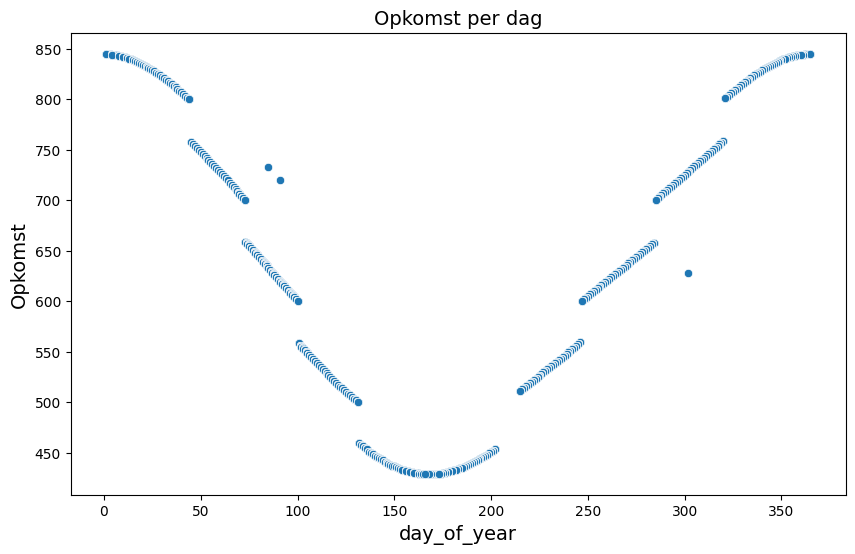

In [263]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Sort the DataFrame based on 'Opkomst' in descending order
df_merged_sorted = df_merged.sort_values(by='Opkomst', ascending=False)

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='day_of_year', y='Opkomst', data=df_merged_sorted)
plt.title('Opkomst per dag')

# Adjust y-axis ticker
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Show the plot
plt.show()


In [264]:
df_merged.drop("timestamp", axis=1, inplace=True)
df_merged.drop("date", axis=1, inplace=True)
df_merged.drop("timezone", axis=1, inplace=True)
df_merged.drop("kwh", axis=1, inplace=True)

## Create a test set

In [265]:
np.random.seed(42)

In [266]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Take the first 80% of the data as training set
# Rolling window kwh
to_predict = "kwh_per_hour"
df_merged_windowed = df_merged.copy()
df_merged_windowed[to_predict] = df_merged_windowed[to_predict].shift(1)# REMEMEBER THIS

# Remove the first row
df_merged_windowed = df_merged_windowed.iloc[1:]

df_merged_windowed.dropna(inplace=True)


# Bring the data back to a DataFrame
df_merged_windowed = pd.DataFrame(df_merged_windowed, columns=df_merged.columns)

X = df_merged_windowed.drop(columns=[to_predict], axis=1)
y = df_merged_windowed[to_predict]


<Axes: >

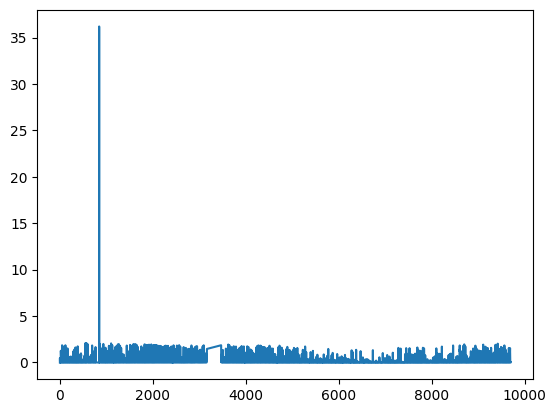

In [267]:
y.plot(kind="line")

#### Split data in train and test set

In [268]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Select and train a model

#### Random forest regressor

In [269]:
from sklearn.ensemble import RandomForestRegressor
model= RandomForestRegressor()
model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
from math import sqrt

y_pred = model.predict(X_test)
model_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", model_rmse)

RMSE: 0.23782127176554044


In [270]:
# mae 
from sklearn.metrics import mean_absolute_error

model_mae = mean_absolute_error(y_test, y_pred)
model_mae

0.08318448053928879

#### Random forest regressor with grid search

In [271]:
from sklearn.pipeline import Pipeline

forest= Pipeline([
        ("scaler", StandardScaler()),
        ("model", RandomForestRegressor())
    ])


In [272]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
model= RandomForestRegressor()
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

param_grid = [
    {'model__n_estimators': [100, 200, 300], 'model__max_depth': [None, 10, 20, 30]},
    { 'model__min_samples_split': [2,5, 10], 'model__min_samples_leaf': [1, 2, 4]},
  ]

grid_search = GridSearchCV(forest, param_grid, cv=5,
                            scoring='neg_mean_squared_error',
                            return_train_score=True)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
best_model

print("best parameters:", grid_search.best_params_)


kwh_predictions = best_model.predict(X_train)
best_model_mse = mean_squared_error(y_train, kwh_predictions)
best_modse = sqrt(best_model_mse)
best_model_mae = mean_absolute_error(y_train, kwh_predictions)

best_model_mse, best_model_mae


best parameters: {'model__min_samples_leaf': 4, 'model__min_samples_split': 10}


(0.13921161264338547, 0.061499055943304404)

In [273]:
import joblib
joblib.dump(best_model, "best_model.joblib")

['best_model.joblib']

#### Linear regression

In [127]:
# linear regression model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

kwh_predictions = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_train, kwh_predictions)
lin_rmse = sqrt(lin_mse)
lin_mae = mean_absolute_error(y_train, kwh_predictions)
lin_rmse, lin_mae



(0.5475443366545957, 0.25749301002532293)

#### Decision tree regressor

In [128]:
# decision tree model
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [129]:

kwh_predictions = tree_reg1.predict(X)
tree_mse = mean_squared_error(y, kwh_predictions)
tree_rmse = sqrt(tree_mse)
tree_rmse

0.5138200828404317

#### Lasso regression

In [130]:
# lasso regression model
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train, y_train)

kwh_predictions = lasso_reg.predict(X_train)
lasso_mse = mean_squared_error(y_train, kwh_predictions)
lasso_rmse = sqrt(lasso_mse)
lasso_rmse

lasso_mae = mean_absolute_error(y_train, kwh_predictions)

lasso_mse, lasso_mae



(0.32068079153878987, 0.2712352772420921)

#### Stochastic Gradient Descent Regressor

In [131]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,n_iter_no_change=100, random_state=42)
# n_iter_no_change=100 means that the training will stop after 100 epochs without improvement
sgd_reg.fit(X, y.ravel())

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [132]:
sgd_reg.intercept_, sgd_reg.coef_

(array([0.24912617]),
 array([ 0.12728879, -0.18138503,  0.03180567, -0.04476224,  0.08745835,
        -0.06797678,  0.06747653,  0.02506486, -0.08411944]))

In [133]:
from sklearn.metrics import mean_squared_error
from math import sqrt

kwh_predictions = sgd_reg.predict(X)
sgd_mse = mean_squared_error(y, kwh_predictions)

sgd_rmse = sqrt(sgd_mse)
sgd_rmse


from sklearn.metrics import mean_absolute_error

sgd_mae = mean_absolute_error(y, kwh_predictions)
sgd_mae

0.2550236575209849

#### Polynomial Regression

In [134]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
# include_bias=False means that the PolynomialFeatures class will not add the bias term (x0 = 1) for us
X_poly = poly_features.fit_transform(X)

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)


LinearRegression()

In [135]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(0.5427324575975361,
 array([ 1.20861575e-01, -1.08759411e-01,  6.74597054e-02, -6.36092228e-02,
         1.05220116e-01, -5.85597623e-02, -4.02469283e-02,  3.41311309e-02,
        -1.53877446e-01,  2.38448143e-02, -1.83058745e-02,  3.25336218e-02,
        -1.64854714e-02, -4.37854338e-04,  2.18220315e-02,  2.96645016e-03,
        -9.32940118e-03, -1.12856090e-02,  1.63965795e-02, -1.99511693e-02,
        -2.83743443e-03, -1.83300904e-01,  4.20139357e-02, -1.61497160e-01,
        -8.29542630e-03,  3.22432333e-02,  9.83165812e-03, -1.45603909e-02,
        -5.02599115e-02, -2.41216901e-03, -3.88060031e-02,  3.07906435e-03,
        -1.78637637e-02, -1.10494948e-02,  9.05621036e-02,  1.04018561e-02,
         7.86206246e-02, -1.96133609e-02,  4.44414346e-02, -1.01603632e+00,
         5.22903093e-01, -2.17020686e+00, -6.53365047e-02, -1.89084189e-02,
        -4.38583884e-02,  5.69252218e-01,  1.38230955e-05,  1.08893257e-01,
        -1.17848400e+00, -4.33411405e-02, -6.51046462e-02, -1.73939

In [136]:
from sklearn.metrics import mean_squared_error
from math import sqrt

kwh_predictions = lin_reg.predict(X_poly)
lin_mse = mean_squared_error(y, kwh_predictions)
lin_rmse = sqrt(lin_mse)
lin_rmse

from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y, kwh_predictions)
lin_mae


0.22416202555011025

#### learning curve

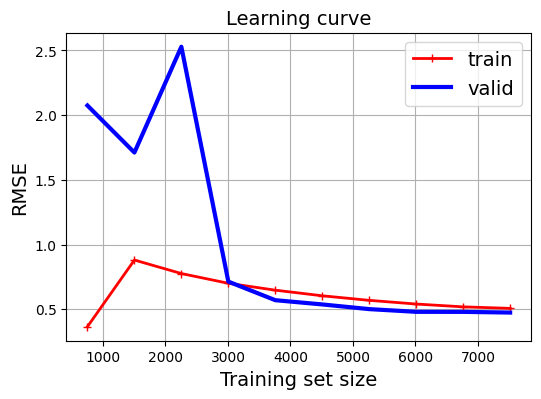

In [137]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.1, 1.0, 10),
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)
# learning_curve() returns the scores of the model on the training set and the validation set


plt.figure(figsize=(6, 4))  
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.title("Learning curve")
plt.show()